# 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install DiadFit --upgrade 

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
import os
pf.__version__

'0.0.59'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [30]:
MasterFolder = r"C:\Users\charl\Documents\Instruments and calibrations"
DayFolder = os.path.join(MasterFolder, "UCB_4-10-23")

meta_path=DayFolder +  '\Metadata'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')

In [31]:
exclude_str=['nodiad','FG','series','IMG','CRR']

Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='N', 
exclude_str=exclude_str, sort=False)

Ne_files[0:5]

['001 Ne1.txt', '002 Ne2.txt', '004 Ne3.txt', '006 Ne4.txt', '008 Ne5.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [32]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,818.699523,5000.0,556.27662
9,1117.086987,5000.0,565.66588
16,1310.480205,5000.0,571.92248
19,1398.915133,5000.0,574.82985
23,1447.564622,7000.0,576.44188


### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [33]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1117.086987,1447.564622,1117,1447


## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [34]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

001 Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

,Peak1_cent,Peak1_height,Peak2_cent,Peak2_height,Peak1_prom,Peak2_prom
0,1116.16583,3816.0,1447.663174,49820.0,3109.700018,49113.700018


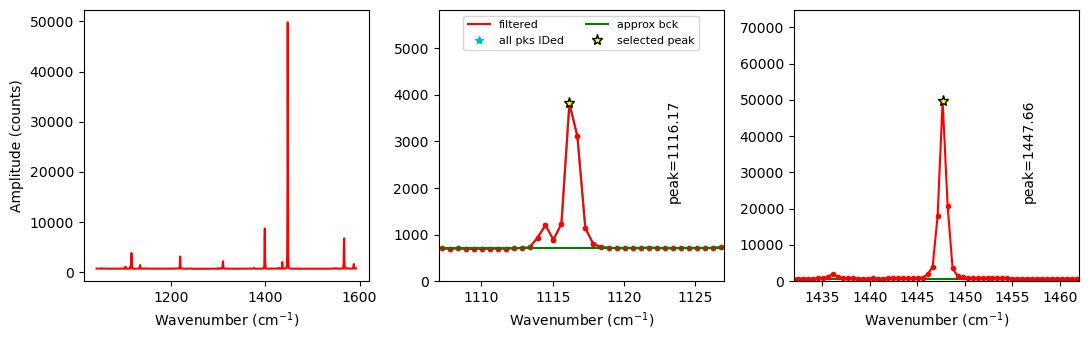

In [35]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [36]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [37]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[2, 5],
pk1_sigma=0.6, pk2_sigma=0.5,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

,filename,1σ_Ne_Corr_test,1σ_Ne_Corr,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,...,pk1_gamma,error_pk1,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,001 Ne1.txt,0.000036,0.000036,1447.684499,52093.340447,0.4377,None,0.00206,0.372678,1116.387058,...,None,0.01181,0.446625,331.297441,0.997525,0.997484,0.997567,109.295805,16.906065,126.201869


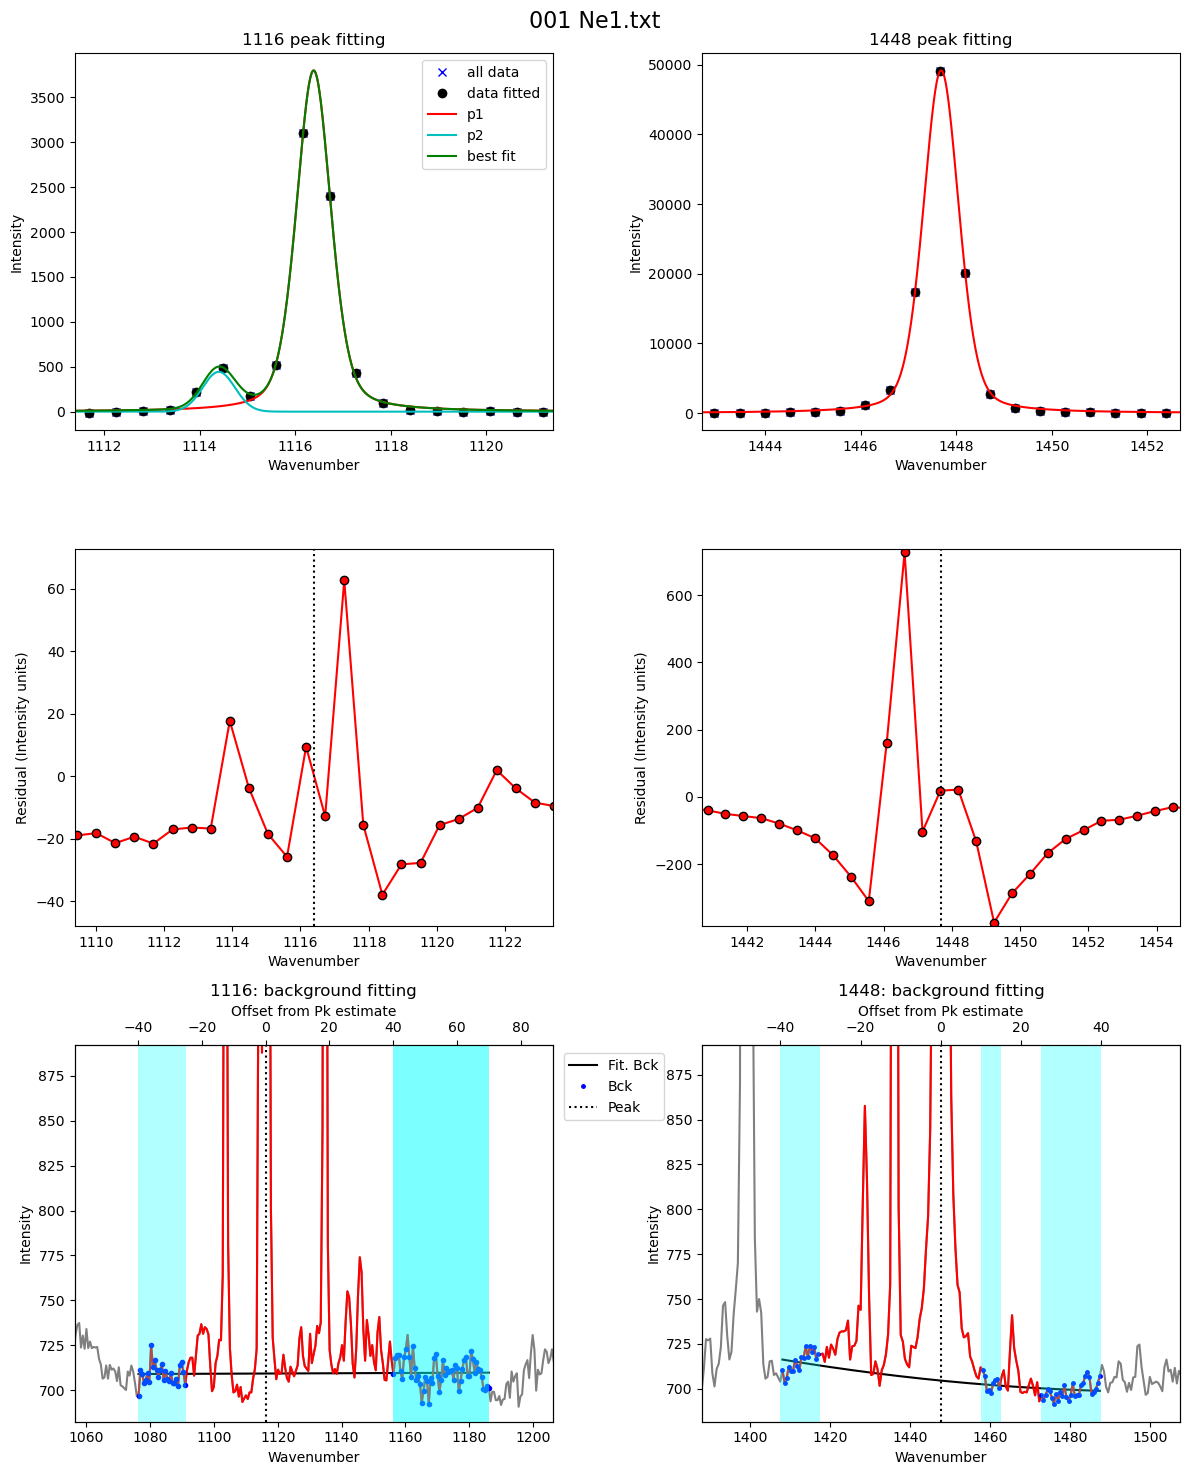

In [38]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [39]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

In [40]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=False)

  0%|          | 0/103 [00:00<?, ?it/s]

In [41]:
df2['1σ_Ne_Corr'].head()

0    0.000036
1    0.000037
2    0.000038
3    0.000037
4    0.000040
Name: 1σ_Ne_Corr, dtype: float64

## Now extract metadata to get a timestamp for each file

In [42]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='N', 
exclude_str=exclude_str, sort=False)

Ne_files_meta#[0:5]

['001 Ne1.txt',
 '002 Ne2.txt',
 '004 Ne3.txt',
 '006 Ne4.txt',
 '008 Ne5.txt',
 '010 Ne6.txt',
 '012 Ne7.txt',
 '014 Ne8.txt',
 '016 Ne9.txt',
 '018 Ne10.txt',
 '020 Ne11.txt',
 '021 Ne12.txt',
 '023 Ne13.txt',
 '025 Ne14.txt',
 '027 Ne15.txt',
 '029 Ne16.txt',
 '031 Ne17.txt',
 '033 Ne18.txt',
 '035 Ne19.txt',
 '037 Ne20.txt',
 '039 Ne21.txt',
 '041 Ne22.txt',
 '043 Ne23.txt',
 '045 Ne24+FDCA-P7-4.txt',
 '046 Ne25+FDCA-P7-5.txt',
 '047 Ne26+FDCA-P7-6.txt',
 '048 Ne27.txt',
 '050 Ne28.txt',
 '052 Ne29.txt',
 '054 Ne30.txt',
 '056 Ne31.txt',
 '058 Ne32.txt',
 '060 Ne33.txt',
 '062 Ne34.txt',
 '064 Ne35.txt',
 '066 Ne36.txt',
 '068 Ne37.txt',
 '070 Ne38.txt',
 '072 Ne39.txt',
 '074 Ne40.txt',
 '077 Ne41.txt',
 '079 Ne42.txt',
 '081 Ne43.txt',
 '083 Ne44.txt',
 '086 Ne45.txt',
 '090 Ne46.txt',
 '092 Ne47.txt',
 '094 Ne48.txt',
 '096 Ne49.txt',
 '100 Ne50.txt',
 '102 Ne51.txt',
 '104 Ne52.txt',
 '107 Ne53.txt',
 '111 Ne54.txt',
 '113 Ne55.txt',
 '115 Ne56.txt',
 '117 Ne57.txt',
 '121 Ne58

In [43]:
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=False)
meta.head()

100%|██████████| 103/103 [00:00<00:00, 1137.89it/s]

Done
Oof, try not to work after midnight!


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
71,157 Ne71.txt,"April 11, 2023\n",April,11.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:06:34 AM\n,86794.0,1325.004
72,159 Ne72.txt,"April 11, 2023\n",April,11.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:20:31 AM\n,87631.0,1325.004
73,164 Ne73.txt,"April 11, 2023\n",April,11.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:38:23 AM\n,88703.0,1325.004
74,166 Ne74.txt,"April 11, 2023\n",April,11.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:46:53 AM\n,89213.0,1325.004
75,168 Ne75.txt,"April 11, 2023\n",April,11.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:52:15 AM\n,89535.0,1325.004


In [44]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

001 Ne1.txt


In [45]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

good job, no duplicate file names


array(['157 Ne71', '159 Ne72', '164 Ne73', '166 Ne74', '168 Ne75',
       '173 Ne76', '176 Ne77', '178 Ne78', '182 Ne79',
       '183 Ne80+FDCA-P57-1', '185 Ne81', '188 Ne82', '192 Ne83',
       '196 Ne84', '200 Ne83', '204 Ne84', '208 Ne85', '212 Ne86',
       '216 Ne87', '220 Ne88', '224 Ne89', '228 Ne90', '232 Ne91',
       '236 Ne92', '240 Ne93', '244 Ne94', '248 Ne95', '252 Ne96',
       '256 Ne97', '257 Ne98', '258 Ne99', '259 Ne100', '001 Ne1',
       '002 Ne2', '004 Ne3', '006 Ne4', '008 Ne5', '010 Ne6', '012 Ne7',
       '014 Ne8', '016 Ne9', '018 Ne10', '020 Ne11', '021 Ne12',
       '023 Ne13', '025 Ne14', '027 Ne15', '029 Ne16', '031 Ne17',
       '033 Ne18', '035 Ne19', '037 Ne20', '039 Ne21', '041 Ne22',
       '043 Ne23', '045 Ne24+FDCA-P7-4', '046 Ne25+FDCA-P7-5',
       '047 Ne26+FDCA-P7-6', '048 Ne27', '050 Ne28', '052 Ne29',
       '054 Ne30', '056 Ne31', '058 Ne32', '060 Ne33', '062 Ne34',
       '064 Ne35', '066 Ne36', '068 Ne37', '070 Ne38', '072 Ne39',
       '07

In [46]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

001 Ne1.txt


In [47]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

good job, no duplicate file names


array(['001 Ne1', '002 Ne2', '004 Ne3', '006 Ne4', '008 Ne5', '010 Ne6',
       '012 Ne7', '014 Ne8', '016 Ne9', '018 Ne10', '020 Ne11',
       '021 Ne12', '023 Ne13', '025 Ne14', '027 Ne15', '029 Ne16',
       '031 Ne17', '033 Ne18', '035 Ne19', '037 Ne20', '039 Ne21',
       '041 Ne22', '043 Ne23', '045 Ne24+FDCA-P7-4', '046 Ne25+FDCA-P7-5',
       '047 Ne26+FDCA-P7-6', '048 Ne27', '050 Ne28', '052 Ne29',
       '054 Ne30', '056 Ne31', '058 Ne32', '060 Ne33', '062 Ne34',
       '064 Ne35', '066 Ne36', '068 Ne37', '070 Ne38', '072 Ne39',
       '074 Ne40', '077 Ne41', '079 Ne42', '081 Ne43', '083 Ne44',
       '086 Ne45', '090 Ne46', '092 Ne47', '094 Ne48', '096 Ne49',
       '100 Ne50', '102 Ne51', '104 Ne52', '107 Ne53', '111 Ne54',
       '113 Ne55', '115 Ne56', '117 Ne57', '121 Ne58', '123 Ne59',
       '125 Ne60', '127 Ne61', '131 Ne62', '135 Ne63', '137 Ne64',
       '139 Ne65', '143 Ne66', '146 Ne67', '147 Ne68+FDCA-P41-1',
       '149 Ne68', '153 Ne69', '155 Ne70', '157 Ne71',

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [48]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [49]:
df_combo_sort=df_combo.sort_values(by='filename_x')

nm=os.path.basename(DayFolder)
model_short=''.join(char for char in model_name if char.isupper()) # this extracts the capital letters from the model name, example: PseudoVoigtModel=PVM
df_combo_sort.to_excel("Ne_"+nm+"_"+model_short+".xlsx")
df_combo_sort.to_clipboard(excel=True)
df_combo_sort.head()

,filename_x,Ne_Corr,1σ_Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,001 Ne1.txt,0.997525,0.000036,331.297442,1447.684499,1116.387057,52093.357807,4029.746331,109.296248,16.905787,...,April,10.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",2:31:06 PM\n,52266.0,1325.004
1,002 Ne2.txt,0.997507,0.000037,331.303683,1447.684717,1116.381034,52336.891277,3930.554667,109.526757,18.252094,...,April,10.0,NaN,45.0,3.0,5.0,"['0h', '2m', '16s']",2:39:26 PM\n,52766.0,1325.004
2,004 Ne3.txt,0.997509,0.000038,331.302967,1447.685749,1116.382783,52161.397939,3965.281794,111.751150,17.732528,...,April,10.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",2:44:54 PM\n,53094.0,1325.004
3,006 Ne4.txt,0.997513,0.000037,331.301685,1447.686157,1116.384472,52098.231864,3910.702356,110.264581,17.328132,...,April,10.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",2:49:53 PM\n,53393.0,1325.004
4,008 Ne5.txt,0.997508,0.000040,331.303209,1447.681326,1116.378117,51939.631619,3819.925149,111.743391,16.119185,...,April,10.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",2:57:54 PM\n,53874.0,1325.004


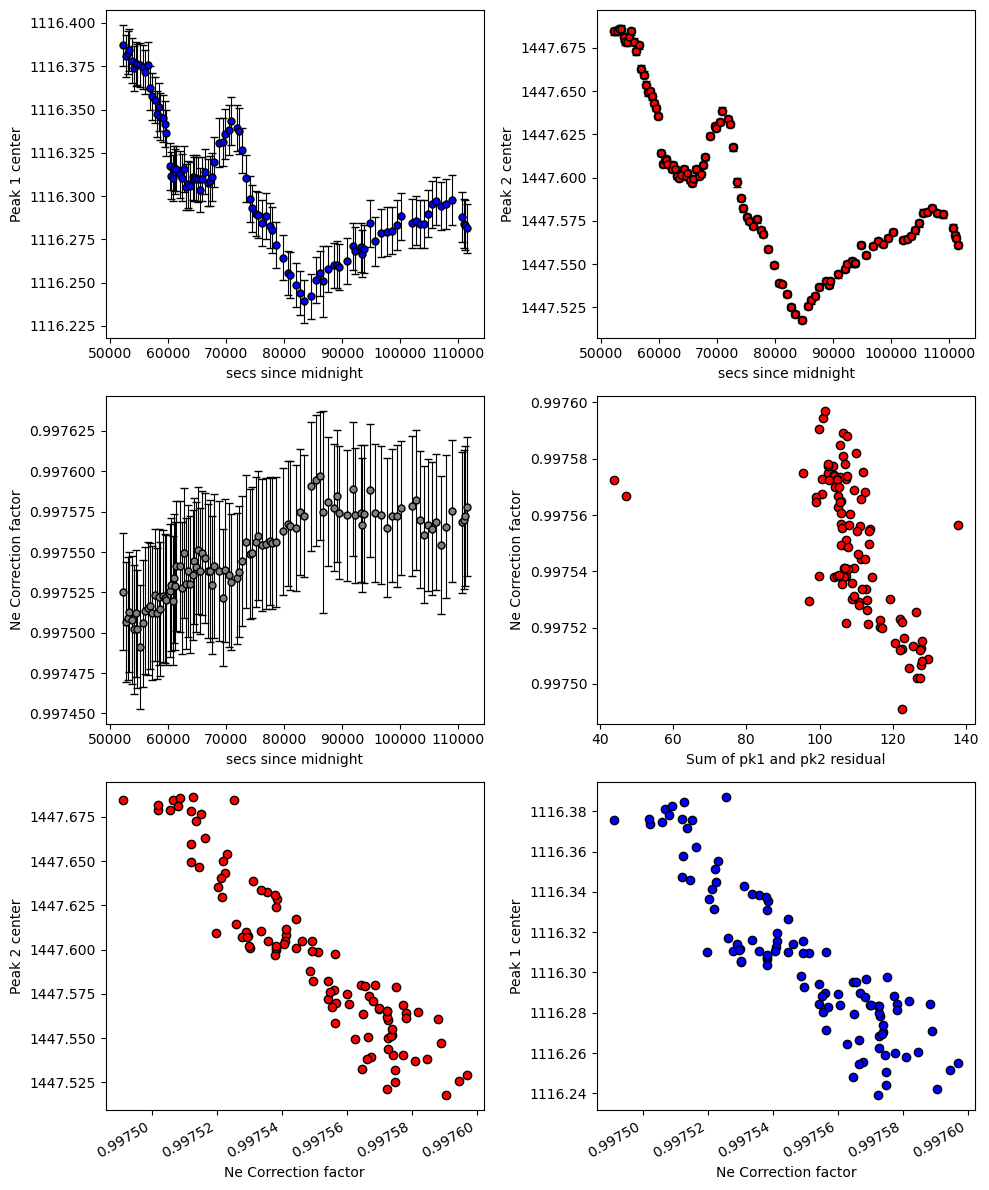

In [51]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right

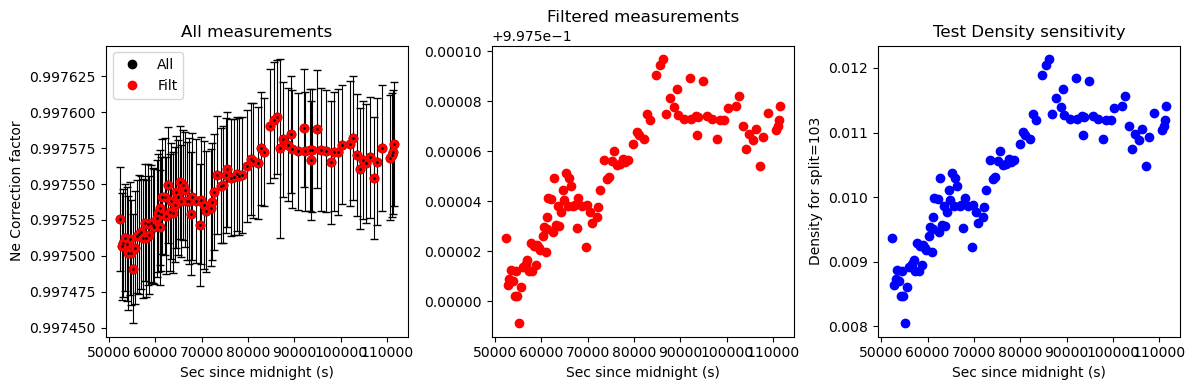

In [52]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=5, offset=0.0002)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

3


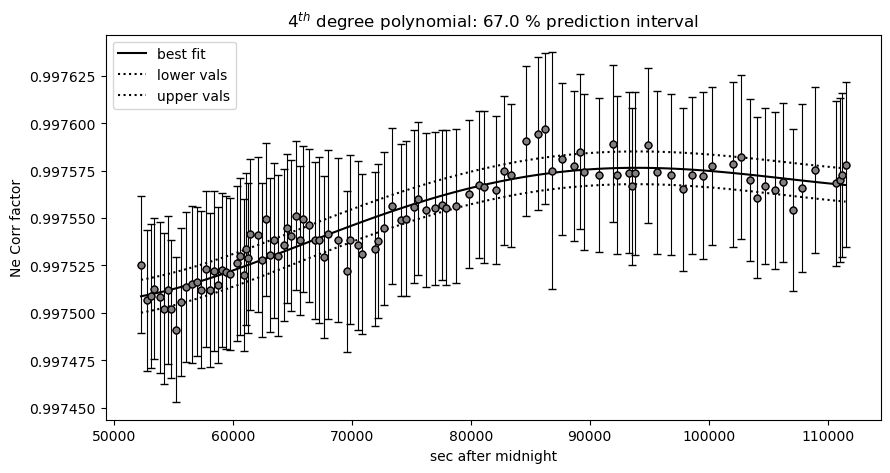

In [61]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
pf.generate_Ne_corr_model(time=df_combo_filt['sec since midnight'], Ne_corr=df_combo_filt, 
N_poly=4, CI=0.67,save_fig=True)


In [62]:
from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step1_Fit_Your_Ne_Lines is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()